# Sine Wave Using RNN

<img src='sine_wave.png' width="500" height="600"/>

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

### Cretae a simple sine wave

In [2]:
x = np.linspace(start=0, stop=50, num=501)
#x

In [3]:
x.shape

(501,)

In [4]:
y = np.sin(x)
y.shape

(501,)

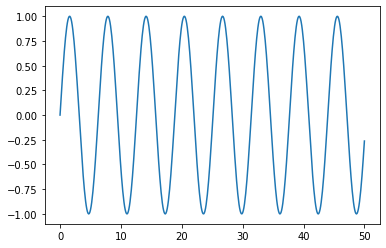

In [5]:
plt.plot(x , y)

### Make a dataframe with x and y = sin(x) data 

In [6]:
df = pd.DataFrame(data=y, index=x, columns=['Sine'])

In [7]:
df

,Sine
0.0,0.000000
0.1,0.099833
0.2,0.198669
0.3,0.295520
0.4,0.389418
...,...
49.6,-0.617439
49.7,-0.535823
49.8,-0.448854
49.9,-0.357400


In [8]:
#Set percentage for test data as 10%
test_percent = 0.1

In [9]:
len(df)

501

In [10]:
test_point = np.round(len(df)*test_percent)
test_point

50.0

In [11]:
test_index = int(len(df)-test_point)
test_index

451

In [12]:
#from 0 to all the way to the end but not including test sets
train = df.iloc[:test_index]
train.shape

(451, 1)

In [13]:
#train

In [14]:
#from test_index point to all the way to the end
test = df.iloc[test_index:]
test.shape

(50, 1)

In [15]:
#test

### Pre processing of datasets 

In [16]:
from sklearn.preprocessing import MinMaxScaler

In [17]:
scaler = MinMaxScaler()

In [18]:
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [19]:
scaled_train = scaler.transform(train)
scaled_train[:10]

array([[0.49999912],
       [0.54991622],
       [0.59933458],
       [0.64776041],
       [0.69470985],
       [0.73971381],
       [0.78232262],
       [0.82211054],
       [0.85868004],
       [0.89166571]])

**Same thing will apply to test sets without fitting**

In [20]:
scaled_test = scaler.transform(test)
scaled_test[:10]

array([[0.94955134],
       [0.96915662],
       [0.98407422],
       [0.99415511],
       [0.99929856],
       [0.99945317],
       [0.9946174 ],
       [0.98483957],
       [0.97021737],
       [0.95089691]])

### Create batches of train data

In [21]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [22]:
#help(TimeseriesGenerator)

    # targets: Targets corresponding to timesteps in `data`.
    # length: Length of the output sequences (in number of timesteps).
    # batch_size: Number of timeseries samples in each batch (except maybe the last one).

In [23]:
length = 2
batch_size = 1
# here data and targets both are scaled_train 
generator = TimeseriesGenerator(data=scaled_train, 
                                targets=scaled_train,
                                length=length, 
                                batch_size=batch_size)

In [24]:
len(scaled_train)

451

In [25]:
# len(generator) = len(scaled_train) - length
len(generator)

449

In [26]:
generator[0]

(array([[[0.49999912],
         [0.54991622]]]),
 array([[0.59933458]]))

In [27]:
# Very First Batch
X, y = generator[0]

In [28]:
print(X)

[[[0.49999912]
  [0.54991622]]]


In [29]:
print(y)

[[0.59933458]]


In [30]:
# Here X mean the first two of train
# y means the predict value

In [31]:
#Let's test it
scaled_train[2]

array([0.59933458])

In [32]:
# So generator[0] takes first two values as input
# and generate 3rd value as output
# So here 'length' plays a very important role
# Keep in mind, larger the length longer the training time

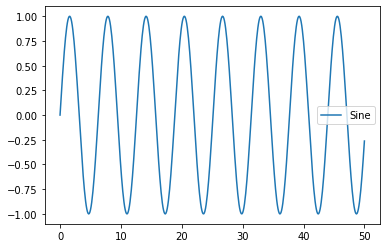

In [33]:
df.plot()

In [34]:
length = 50 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

Now you will be able to edit the length so that it makes sense for your time series!

### Create the Model for training

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,SimpleRNN

In [36]:
# We're only using one feature in our time series
n_features = 1

In [37]:
# define model
model = Sequential()

# Simple RNN layer
model.add(SimpleRNN(50,input_shape=(length, n_features)))

# Final Prediction
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 50)                2600      
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________


In [39]:
# fit model
model.fit_generator(generator,epochs=5)

Epoch 1/5
401/401 [==============================] - 38s 95ms/step - loss: 0.0133
Epoch 2/5
401/401 [==============================] - 37s 92ms/step - loss: 1.3578e-04
Epoch 3/5
401/401 [==============================] - 39s 97ms/step - loss: 5.4074e-04
Epoch 4/5
401/401 [==============================] - 41s 102ms/step - loss: 2.6196e-04
Epoch 5/5
401/401 [==============================] - 35s 88ms/step - loss: 3.8131e-04


In [40]:
losses = pd.DataFrame(model.history.history)

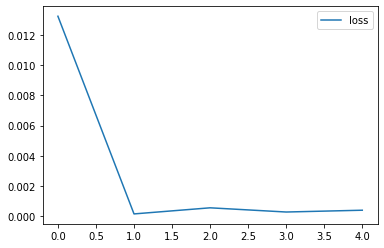

In [41]:
losses.plot()

### Evaluate on Test Data

In [43]:
first_eval_batch = scaled_train[-length:]

In [44]:
first_eval_batch.shape

(50, 1)

In [45]:
first_eval_batch = first_eval_batch.reshape(1, length, n_features)

In [46]:
first_eval_batch.shape

(1, 50, 1)

In [47]:
model.predict(first_eval_batch)

array([[0.9587259]], dtype=float32)

In [48]:
scaled_test[0]

array([0.94955134])

Now let's put this logic in a for loop to predict into the future for the entire test range.

In [49]:
test_prediction = []
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape(1, length, n_features)

In [50]:
current_batch.shape

(1, 50, 1)

In [51]:
current_batch

array([[[8.37405820e-01],
        [7.98881698e-01],
        [7.57371240e-01],
        [7.13289205e-01],
        [6.67076045e-01],
        [6.19193508e-01],
        [5.70120021e-01],
        [5.20345908e-01],
        [4.70368497e-01],
        [4.20687145e-01],
        [3.71798252e-01],
        [3.24190300e-01],
        [2.78338972e-01],
        [2.34702398e-01],
        [1.93716581e-01],
        [1.55791039e-01],
        [1.21304709e-01],
        [9.06021693e-02],
        [6.39901882e-02],
        [4.17346643e-02],
        [2.40579672e-02],
        [1.11367167e-02],
        [3.10001778e-03],
        [2.81703720e-05],
        [1.95186738e-03],
        [8.85188786e-03],
        [2.06592891e-02],
        [3.72560954e-02],
        [5.84764771e-02],
        [8.41084070e-02],
        [1.13895779e-01],
        [1.47540969e-01],
        [1.84707803e-01],
        [2.25024924e-01],
        [2.68089497e-01],
        [3.13471233e-01],
        [3.60716695e-01],
        [4.09353821e-01],
        [4.5

In [52]:
# here, drop the very fast point
np.append(current_batch[:,1:,:],[[[99]]],axis=1)

array([[[7.98881698e-01],
        [7.57371240e-01],
        [7.13289205e-01],
        [6.67076045e-01],
        [6.19193508e-01],
        [5.70120021e-01],
        [5.20345908e-01],
        [4.70368497e-01],
        [4.20687145e-01],
        [3.71798252e-01],
        [3.24190300e-01],
        [2.78338972e-01],
        [2.34702398e-01],
        [1.93716581e-01],
        [1.55791039e-01],
        [1.21304709e-01],
        [9.06021693e-02],
        [6.39901882e-02],
        [4.17346643e-02],
        [2.40579672e-02],
        [1.11367167e-02],
        [3.10001778e-03],
        [2.81703720e-05],
        [1.95186738e-03],
        [8.85188786e-03],
        [2.06592891e-02],
        [3.72560954e-02],
        [5.84764771e-02],
        [8.41084070e-02],
        [1.13895779e-01],
        [1.47540969e-01],
        [1.84707803e-01],
        [2.25024924e-01],
        [2.68089497e-01],
        [3.13471233e-01],
        [3.60716695e-01],
        [4.09353821e-01],
        [4.58896644e-01],
        [5.0

**NOTE: PAY CLOSE ATTENTION HERE TO WHAT IS BEING OUTPUTED AND IN WHAT DIMENSIONS. ADD YOUR OWN PRINT() STATEMENTS TO SEE WHAT IS TRULY GOING ON!!**

In [53]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [54]:
test_predictions

[array([0.9587259], dtype=float32),
 array([0.97429895], dtype=float32),
 array([0.9915468], dtype=float32),
 array([1.0012385], dtype=float32),
 array([1.0079482], dtype=float32),
 array([1.0088084], dtype=float32),
 array([1.0022845], dtype=float32),
 array([0.99375856], dtype=float32),
 array([0.97544175], dtype=float32),
 array([0.9556069], dtype=float32),
 array([0.9309776], dtype=float32),
 array([0.90325356], dtype=float32),
 array([0.87085694], dtype=float32),
 array([0.8328015], dtype=float32),
 array([0.79520875], dtype=float32),
 array([0.75250024], dtype=float32),
 array([0.71065074], dtype=float32),
 array([0.6631151], dtype=float32),
 array([0.6157533], dtype=float32),
 array([0.56622624], dtype=float32),
 array([0.5160404], dtype=float32),
 array([0.4665211], dtype=float32),
 array([0.41436443], dtype=float32),
 array([0.36586004], dtype=float32),
 array([0.31410807], dtype=float32),
 array([0.2681304], dtype=float32),
 array([0.22210364], dtype=float32),
 array([0.18042

In [55]:
scaled_test

array([[9.49551344e-01],
       [9.69156618e-01],
       [9.84074225e-01],
       [9.94155114e-01],
       [9.99298559e-01],
       [9.99453170e-01],
       [9.94617400e-01],
       [9.84839568e-01],
       [9.70217371e-01],
       [9.50896908e-01],
       [9.27071224e-01],
       [8.98978376e-01],
       [8.66899060e-01],
       [8.31153800e-01],
       [7.92099752e-01],
       [7.50127132e-01],
       [7.05655314e-01],
       [6.59128649e-01],
       [6.11012013e-01],
       [5.61786173e-01],
       [5.11942978e-01],
       [4.61980443e-01],
       [4.12397778e-01],
       [3.63690397e-01],
       [3.16344967e-01],
       [2.70834550e-01],
       [2.27613868e-01],
       [1.87114770e-01],
       [1.49741909e-01],
       [1.15868702e-01],
       [8.58335998e-02],
       [5.99367021e-02],
       [3.84367625e-02],
       [2.15486014e-02],
       [9.44095974e-03],
       [2.23481297e-03],
       [2.16257798e-06],
       [2.76531647e-03],
       [1.04966661e-02],
       [2.31189624e-02],


### Inverse Transformations and Compare

In [56]:
true_predictions = scaler.inverse_transform(test_predictions)

In [57]:
#true_predictions

In [58]:
# IGNORE WARNINGS
test['Predictions'] = true_predictions

E:\Anaconda Program Data\Program Data\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [59]:
test.head()

,Sine,Predictions
45.1,0.899097,0.917446
45.2,0.938307,0.948592
45.3,0.968142,0.983087
45.4,0.988304,1.002471
45.5,0.998591,1.015890


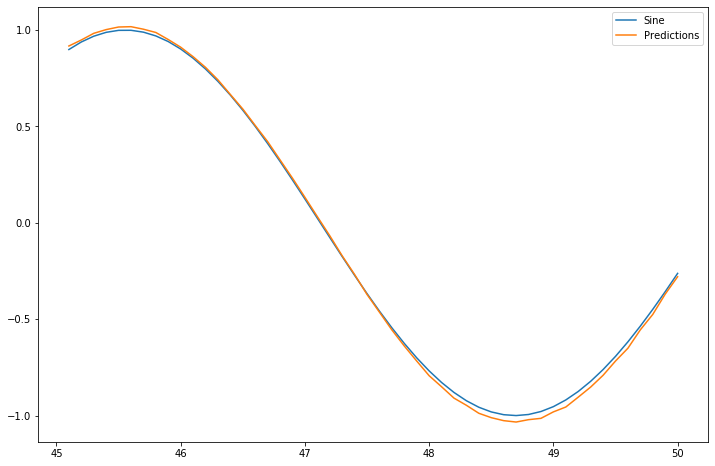

In [60]:
test.plot(figsize=(12,8))

### Adding in Early Stopping and Validation Generator

In [61]:
from tensorflow.keras.callbacks import EarlyStopping

In [62]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [63]:
length = 49
generator = TimeseriesGenerator(scaled_train,scaled_train,
                               length=length,batch_size=1)


validation_generator = TimeseriesGenerator(scaled_test,scaled_test,
                                          length=length,batch_size=1)

## LSTMS

In [64]:
# define model
model = Sequential()

# Simple RNN layer
model.add(LSTM(50,input_shape=(length, n_features)))

# Final Prediction
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [65]:
model.fit_generator(generator,epochs=20,
                   validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/20
402/402 [==============================] - 67s 166ms/step - loss: 0.0111 - val_loss: 1.0841e-04
Epoch 2/20
402/402 [==============================] - 69s 171ms/step - loss: 3.8842e-04 - val_loss: 3.6466e-06
Epoch 3/20
402/402 [==============================] - 66s 165ms/step - loss: 8.4943e-05 - val_loss: 1.1438e-05
Epoch 4/20
402/402 [==============================] - 64s 160ms/step - loss: 3.7416e-05 - val_loss: 1.3892e-05


In [66]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

E:\Anaconda Program Data\Program Data\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


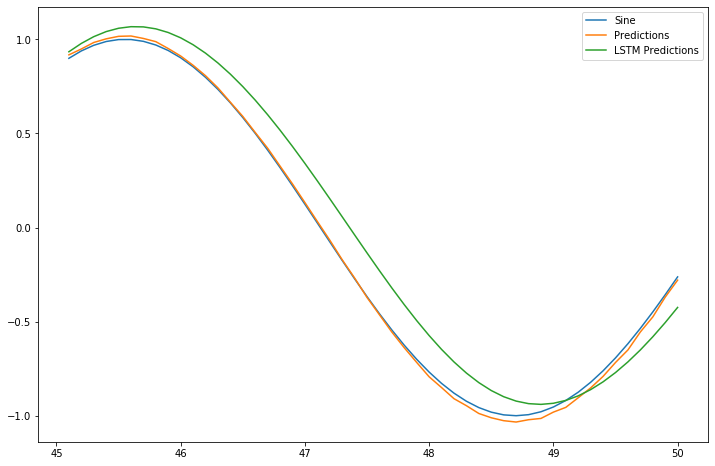

In [67]:
# IGNORE WARNINGS
true_predictions = scaler.inverse_transform(test_predictions)
test['LSTM Predictions'] = true_predictions
test.plot(figsize=(12,8))

### Forecasting

Forecast into unknown range. We should first utilize all our data, since we are now forecasting!

In [68]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [69]:
length = 50 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [70]:
model = Sequential()
model.add(LSTM(50, input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator,epochs=6)

Epoch 1/6
451/451 [==============================] - 74s 164ms/step - loss: 0.0120
Epoch 2/6
451/451 [==============================] - 74s 164ms/step - loss: 1.5268e-04
Epoch 3/6
451/451 [==============================] - 74s 164ms/step - loss: 1.8105e-04
Epoch 4/6
451/451 [==============================] - 73s 162ms/step - loss: 2.3032e-04
Epoch 5/6
451/451 [==============================] - 76s 169ms/step - loss: 1.9434e-04
Epoch 6/6
451/451 [==============================] - 82s 182ms/step - loss: 9.0796e-05


In [71]:
forecast = []

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [72]:
forecast = scaler.inverse_transform(forecast)
len(forecast)

50

In [73]:
forecast_index = np.arange(50.1,55.1,step=0.1)
len(forecast_index)

50

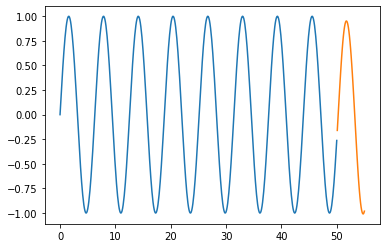

In [74]:
plt.plot(df.index,df['Sine'])
plt.plot(forecast_index,forecast)

In [ ]:
Nice Prediction!